<a href="https://colab.research.google.com/github/terryspitz/ipython_notebooks/blob/master/deeper/deeperfont_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeeperFont transformer
Copied from https://www.tensorflow.org/tutorials/text/transformer
See https://github.com/terryspitz/ipython_notebooks/blob/master/deeper/README.md


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

## Imports

In [2]:
import time
from enum import Enum, IntEnum

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageChops, ImageFont


In [3]:
# Connect to Google Drive to read fonts
# from https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup input pipeline

In [4]:
class Stroke(IntEnum):
    """
    Enum defining data contents of last dimension
    """
    PX = 0
    PY = 1
    PenDown = 2  # +1 draw stroke, 0 if this stroke is hidden, i.e. to move between contours in the glyph
    EndOfGlyph = 3  # +1 indicates this stroke is the last of the current glyph, else 0
    Size = 4  # size of this enum

def parse_proto(example_proto):
  features = {
    'glyphNum': tf.io.FixedLenFeature([], tf.int64),
    'outline': tf.io.FixedLenFeature([MAX_OUTLINE_POINTS*Stroke.Size], tf.int64),
  }
  return tf.io.parse_single_example(example_proto, features)


In [5]:
def drawOutlines(outlines, cellsize, glyphCount):
  """Draw outline tensor."""
  assert len(outlines.shape) == 3
  assert outlines.dtype in [tf.int32, tf.int64]

  im = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0))
  def drawPoints(im, points):
    if len(points)<=2:
      return im
    #temporary image to use to xor each part with main image
    im2 = Image.new('1', size=(glyphCount*cellsize, outlines.shape[0]*cellsize), color=(0)) 
    draw = ImageDraw.Draw(im2).polygon(points, fill=1)
    return ImageChops.logical_xor(im, im2)
  scale = cellsize / MAX_COORD
  for font in range(outlines.shape[0]):
    i = 0
    for glyphNum in range(glyphCount):
      points = []
      x0,y0 = (glyphNum * cellsize, (font+1) * cellsize)
      while True:
        x = x0 + float(outlines[font,i,Stroke.PX])*scale
        y = y0 - float(outlines[font,i,Stroke.PY])*scale
        #print(outlines[font,i], x,y)
        if outlines[font,i,Stroke.PenDown]>0:
          points += (x,y)
        else:
          im = drawPoints(im, points)
          points=[(x,y)]
        i+=1
        if outlines[font,i,Stroke.EndOfGlyph]>0 or i>=outlines.shape[1]:
          break
      im = drawPoints(im, points)
  return im


{'glyphNum': <tf.Tensor: shape=(), dtype=int64, numpy=26>, 'outline': <tf.Tensor: shape=(8000,), dtype=int64, numpy=array([123,  15,   0, ...,   0,   0,   0])>}
tf.Tensor(
[[[164  20   0   0]
  [169  20   1   0]]

 [[ 72  -3   0   0]
  [ 60  -3   1   0]]], shape=(2, 2, 4), dtype=int32)
outline shape (batch_size, points_per_outline, Stroke.Size):  (16, 2000, 4)


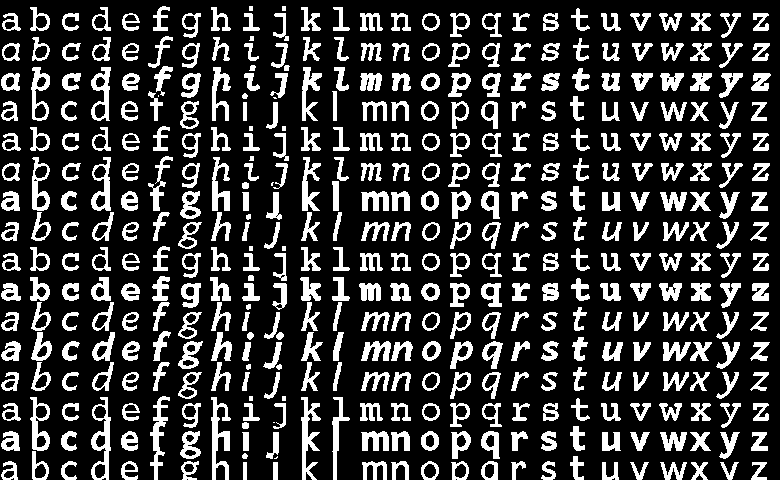

In [6]:
filename = '/content/drive/My Drive/Colab Notebooks/fonts/fonts8b.tfrecords'
#max_points_per_scanline = 10 # required for g, m
MAX_OUTLINE_POINTS = 2000
COORDINATE_BITS = 8
MAX_COORD = 2**COORDINATE_BITS

buffer_size=10000
batch_size=16
dataset = tf.data.TFRecordDataset(filename)
dataset = dataset.map(parse_proto)
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

for next_element in dataset:
  print(next_element)
  assert next_element["glyphNum"].numpy() == 26
  assert next_element["outline"].shape == MAX_OUTLINE_POINTS * Stroke.Size
  break

glyphNum = next_element["glyphNum"].numpy()

dataset = dataset.map(lambda elem: tf.cast(tf.reshape(elem["outline"], [MAX_OUTLINE_POINTS, Stroke.Size]), tf.int32))
dataset = dataset.padded_batch(batch_size)
dataset = dataset.cache()

for next_element in dataset:
  print(next_element[0:2,0:2])
  assert next_element.shape == [batch_size, MAX_OUTLINE_POINTS, Stroke.Size]
  break

print("outline shape (batch_size, points_per_outline, Stroke.Size): ", next_element.shape)
display(drawOutlines(next_element, cellsize=30, glyphCount=glyphNum))

# with tf.Session():
#   y_divisions = 30
#   max_points_per_scanline = 8
#   ygrid = np.linspace(0.0, 1.0, y_divisions, endpoint=False) #y coordinates to render on
#   scanlines = outlinesToScanlines(outlines[0], max_points_per_scanline, ygrid, glyphNum)
#   print("scanlines shape (glyphs, lines, max_points_per_line): ", scanlines.shape)
#   display(drawScanLines(scanlines.eval(), ygrid, 30))
  
train_dataset = dataset


## Positional encoding


In [7]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [8]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2000, 512)


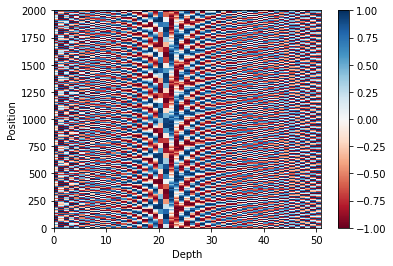

In [9]:
pos_encoding = positional_encoding(2000, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 51))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

In [10]:
def create_padding_mask(seq, assert_shape=True):
  assert len(seq.shape)==3
  print(seq.shape)
  if assert_shape and seq.shape[0]:
    assert seq.shape in [[batch_size, MAX_OUTLINE_POINTS, Stroke.Size],
                         [batch_size, MAX_OUTLINE_POINTS-1, Stroke.Size],
                        ], seq.shape
  end = tf.argmax(seq[:,:,Stroke.EndOfGlyph], axis=1, output_type=tf.int32)
  if assert_shape and seq.shape[0]:
    assert end.shape == [batch_size], f'end.shape {end.shape} != [batch_size {batch_size}]'
  end = end[:,tf.newaxis]
  range = tf.range(seq.shape[1])[tf.newaxis, :]
  range = tf.repeat(range, [seq.shape[0]], axis=0)
  mask = range>end
  # add extra dimensions to add the padding
  # to the attention logits.
  return mask[:, tf.newaxis, :]  # (batch_size, 1, seq_len)

In [11]:
x = tf.constant([[[7, 6, 0, 0], [1, 2, 0, 1], [0, 0, 0, 0]],
                 [[7, 6, 0, 1], [1, 2, 0, 1], [0, 0, 0, 0]]])
create_padding_mask(x, assert_shape=False)

(2, 3, 4)


<tf.Tensor: shape=(2, 1, 3), dtype=bool, numpy=
array([[[False, False,  True]],

       [[False,  True,  True]]])>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third word, only the first and second word will be used. Similarly to predict the fourth word, only the first, second and the third word will be used and so on.

In [12]:
# def create_look_ahead_mask(size):
#   mask = 1 - tf.cast(tf.linalg.band_part(tf.ones((size, size)), -1, 0),tf.int32)
  # return mask  # (seq_len, seq_len)

In [13]:
# x = tf.random.uniform((1, 3))
# temp = create_look_ahead_mask(x.shape[1])
# temp

## Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)

    self.attention = tf.keras.layers.Attention(causal=True)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    assert q.dtype == tf.float32
    assert v.dtype == tf.float32
    assert k.dtype == tf.float32

    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    # scaled_attention = scaled_dot_product_attention(q, k, v, mask)
    scaled_attention = self.attention([q, v, k], [None, mask])
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [21]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 500))  # (batch_size, encoder_sequence, d_model)
out = temp_mha(y, k=y, q=y, mask=None)
out.shape

TensorShape([1, 60, 512])

## Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [22]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [23]:
sample_ffn = point_wise_feed_forward_network(512, 20)
sample_ffn(tf.random.uniform((16, 2000, 4))).shape

TensorShape([16, 2000, 512])

## Gray codes
Used to encode the XY coordinates into separate bits on which the model is trained.

In [24]:
def BinaryToGray(num):
  assert num.dtype == tf.int32
  return tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 1))

def GrayToBinary32(num):
  assert num.dtype == tf.int32
  num = tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 16))
  num = tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 8))
  num = tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 4))
  num = tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 2))
  num = tf.bitwise.bitwise_xor(num, tf.bitwise.right_shift(num, 1))
  return num

print('BinaryToGray', BinaryToGray(tf.range(10)))
print('GrayToBinary32', GrayToBinary32(tf.range(10)))
print('Identity', GrayToBinary32(BinaryToGray(tf.range(20))))
print()

def split_bits(num, bits):
  assert num.dtype == tf.int32
  mask = tf.ones_like(num)
  mask = tf.expand_dims(mask, -1)
  shifts = tf.range(bits)
  shifts = tf.reshape(shifts, [1]*len(num.shape)+shifts.shape)
  mask = tf.bitwise.left_shift(mask, shifts)
  return tf.cast(tf.bitwise.bitwise_and(tf.expand_dims(num, -1), mask)>0, tf.int32)

def merge_bits(num):
  assert num.dtype == tf.int32
  merged_shape = num.shape[:-1]
  mask = tf.ones(merged_shape, dtype=tf.int32)
  mask = tf.expand_dims(mask, -1)
  shifts = tf.range(num.shape[-1])
  shifts = tf.reshape(shifts, [1]*len(merged_shape)+shifts.shape)
  mask = tf.bitwise.left_shift(mask, shifts)
  return tf.reduce_sum(num * mask, axis=-1)

print('split_bits')
print(split_bits(tf.range(10), 3))
print('merge_bits')
print(merge_bits(split_bits(tf.range(10), 3)))
print(merge_bits(split_bits(tf.range(10), 4)))

BinaryToGray tf.Tensor([ 0  1  3  2  6  7  5  4 12 13], shape=(10,), dtype=int32)
GrayToBinary32 tf.Tensor([ 0  1  3  2  7  6  4  5 15 14], shape=(10,), dtype=int32)
Identity tf.Tensor([ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19], shape=(20,), dtype=int32)

split_bits
tf.Tensor(
[[0 0 0]
 [1 0 0]
 [0 1 0]
 [1 1 0]
 [0 0 1]
 [1 0 1]
 [0 1 1]
 [1 1 1]
 [0 0 0]
 [1 0 0]], shape=(10, 3), dtype=int32)
merge_bits
tf.Tensor([0 1 2 3 4 5 6 7 0 1], shape=(10,), dtype=int32)
tf.Tensor([0 1 2 3 4 5 6 7 8 9], shape=(10,), dtype=int32)


## Decoder layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [25]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, training, 
          #  look_ahead_mask, 
           padding_mask):
    assert x.dtype == tf.float32
    attn1 = self.mha1(x, x, x, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2 = self.mha2(out1, out1, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3

In [26]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), False, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

## Decoder

 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [27]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, 
          #  look_ahead_mask, 
           padding_mask):
    assert x.shape in [(batch_size, MAX_OUTLINE_POINTS, Stroke.Size),
                       (batch_size, MAX_OUTLINE_POINTS-1, Stroke.Size)]
    assert x.dtype == tf.int32, f'dtype {x.dtype} != tf.int32'

    seq_len = tf.shape(x)[1]
    
    # Encode with Gray code
    x = tf.concat(
        [
          split_bits(BinaryToGray(x[:,:,Stroke.PX]), COORDINATE_BITS),
          split_bits(BinaryToGray(x[:,:,Stroke.PY]), COORDINATE_BITS),
          x[:,:,Stroke.PenDown:]
        ], axis = -1)
    assert x.shape in [(batch_size, MAX_OUTLINE_POINTS, 2*COORDINATE_BITS+2),
                       (batch_size, MAX_OUTLINE_POINTS-1, 2*COORDINATE_BITS+2)], (
        f'{x.shape}!=({batch_size}, {MAX_OUTLINE_POINTS}, {2*COORDINATE_BITS+2})')
    x = tf.cast(x, tf.float32)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    assert (self.d_model % x.shape[-1]) == 0, f'({self.d_model} % {x.shape[-1]}) !=0'
    x = tf.repeat(x, self.d_model // x.shape[-1], -1)
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, training, 
                                            #  look_ahead_mask,
                                             padding_mask)
    # x.shape == (batch_size, target_seq_len, d_model)
    return x

In [28]:
sample_decoder = Decoder(num_layers=2, d_model=18*8, num_heads=2, 
                         dff=2048, maximum_position_encoding=MAX_OUTLINE_POINTS)
temp_input = tf.random.uniform((16, MAX_OUTLINE_POINTS, 4), dtype=tf.int32, minval=0, maxval=256)

output = sample_decoder(temp_input, 
                              training=False,
                              # look_ahead_mask=None, 
                              padding_mask=None)

output.shape

TensorShape([16, 2000, 144])

## Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [29]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, 
               pe_target, rate=0.1):
    super(Transformer, self).__init__()
    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           pe_target, rate)
    self.final_layer = tf.keras.layers.Dense(Stroke.Size, tf.sigmoid)
    
  def call(self, inp, training, 
          #  look_ahead_mask,
           dec_padding_mask):

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output = self.decoder(
        inp, training, 
        # look_ahead_mask, 
        dec_padding_mask)
    
    x = self.final_layer(dec_output)
    return x

In [30]:
sample_transformer = Transformer(
    num_layers=2, d_model=2*COORDINATE_BITS+2,
    num_heads=2, dff=2048, 
    pe_target=MAX_OUTLINE_POINTS)

temp_input = tf.random.uniform((batch_size, MAX_OUTLINE_POINTS, Stroke.Size), dtype=tf.int32, minval=0, maxval=200)
# temp_target = tf.random.uniform((batch_size, MAX_OUTLINE_POINTS, Stroke.Size), dtype=tf.int32, minval=0, maxval=200)

dec_padding_mask=create_padding_mask(temp_input, assert_shape=False)
print(dec_padding_mask.shape)

fn_out = sample_transformer(temp_input, training=False, 
                              #  look_ahead_mask=None,
                               dec_padding_mask=dec_padding_mask)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)
print(temp_input[0, :10])
print(fn_out[0, :10])

(16, 2000, 4)
(16, 1, 2000)
(16, 2000, 4)
tf.Tensor(
[[195  22  55  54]
 [190 165 104  49]
 [156 184 177 132]
 [ 26  27 100 185]
 [ 79 192 180 130]
 [ 64  53 158  75]
 [ 29 129  74   4]
 [ 49 108 121  43]
 [190  22  81 150]
 [ 11 170 145  24]], shape=(10, 4), dtype=int32)
tf.Tensor(
[[0.3648979  0.553768   0.4210169  0.2619409 ]
 [0.35964578 0.5572432  0.4157562  0.2735361 ]
 [0.3472718  0.5834975  0.4295826  0.26370686]
 [0.35243836 0.5895086  0.44637898 0.23918352]
 [0.3475749  0.5828185  0.4286063  0.26464552]
 [0.35178378 0.5692157  0.41758558 0.27586257]
 [0.3666178  0.54039484 0.41470832 0.2787303 ]
 [0.356791   0.5569484  0.41269594 0.27919334]
 [0.3567263  0.5822263  0.4391307  0.24240306]
 [0.3562857  0.55214864 0.4119402  0.28636393]], shape=(10, 4), dtype=float32)


## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced. 

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [31]:
num_layers = 4
d_model = 18*8
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

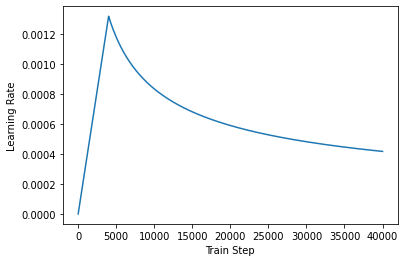

In [34]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [35]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction='none')

In [36]:
def loss_function(real, pred):
  print(f'loss_function: real={real.shape}, pred={pred.shape}')
  loss_ = loss_object(real, pred)

  mask = create_padding_mask(real, assert_shape=False)
  # mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ *= tf.cast(1-mask, dtype=loss_.dtype)
  
  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [37]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

## Training and checkpointing

In [38]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          pe_target=MAX_OUTLINE_POINTS,
                          rate=dropout_rate)
print(transformer)

In [39]:
def create_masks(inp, tar):
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = tf.cast(create_padding_mask(inp), tf.float32)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  # look_ahead_mask = tf.cast(create_look_ahead_mask(tf.shape(tar)[1]), tf.float32)
  # dec_target_padding_mask = tf.cast(create_padding_mask(tar), tf.float32)
  # combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  # print(f'combined_mask {combined_mask.shape}, dec_padding_mask {dec_padding_mask.shape}')
  # return combined_mask, dec_padding_mask
  return dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [40]:
# checkpoint_path = "./checkpoints/train"
checkpoint_path = "/content/drive/My Drive/deeper/checkpoints"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [41]:
EPOCHS = 20

In [44]:
train_step_signature = [
    # tf.TensorSpec(shape=(None, None, None), dtype=tf.int32),
    tf.TensorSpec(shape=(batch_size, MAX_OUTLINE_POINTS, Stroke.Size), dtype=tf.int32),
]

#@tf.function(input_signature=train_step_signature)
def train_step(example):
  tar_inp = example #[:, :-1]
  tar_real = tf.concat([example[:, 1:], example[:, 0:1]], axis=1)
  print(f'example {example.shape}, tar_real {tar_real.shape}')
  
  dec_padding_mask = create_masks(example, tar_inp)
  # combined_mask, dec_padding_mask = create_masks(example, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(tar_inp,
                                 True,
                                #  combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

## Train!!!

In [45]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  for (batch, example) in enumerate(train_dataset):
    train_step(example)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

example (16, 2000, 4), tar_real (16, 2000, 4)
(16, 2000, 4)


InvalidArgumentError: ignored

## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [ ]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]
  
  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0)
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

In [ ]:
def translate(sentence, plot=''):
  result = evaluate(sentence)
  
    # Decode Gray code
  assert x.shape==(batch_size, MAX_OUTLINE_POINTS, 2*COORDINATE_BITS+2), (
      f'{x.shape}!=({batch_size}, {MAX_OUTLINE_POINTS}, {2*COORDINATE_BITS+2})')
  xbits = tf.cast(x[:,:,0:COORDINATE_BITS]>0.5, tf.int32)
  ybits = tf.cast(x[:,:,COORDINATE_BITS:COORDINATE_BITS*2]>0.5, tf.int32)
  x = tf.concat(
      [
        merge_bits(GrayToBinary32(xbits)),
        merge_bits(GrayToBinary32(ybits)),
        x[:,:,-2:]
      ], axis = -1)
  assert x.shape==(batch_size, MAX_OUTLINE_POINTS, Stroke.Size)

  # predicted_sentence = tokenizer_en.decode([i for i in result 
  #                                           if i < tokenizer_en.vocab_size])  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [ ]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [ ]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [ ]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

You can pass different layers and attention blocks of the decoder to the `plot` parameter.

In [ ]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.

Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.